In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import matplotlib.axes as ax
import datetime
import numpy as np
import time
import seaborn as sns
import os
from scipy.stats import zscore

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score, precision_score, recall_score, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.neural_network import MLPClassifier
# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams.update({'font.size': 15})

In [ ]:
import os
os.getcwd()

In [3]:
def model_classification_results(y_pred, y_prob):
    print('Model recall: %.5f' % recall_score(y_test, y_pred))
    print('Model precision_score: %.5f' % precision_score(y_test, y_pred))
    print('Model roc_auc_score: %.5f' % roc_auc_score(y_test, y_pred))
    print('Model accuracy_score: %.5f' % accuracy_score(y_test,y_pred))

    confusion_matrix_pred = pd.DataFrame(confusion_matrix(y_test, y_pred),
                                            columns=pd.MultiIndex.from_product([['Prediction'], ['Fully Paid', 'Charged Off']]),
                                            index=pd.MultiIndex.from_product([['Actual'], ['Fully Paid', 'Charged Off']]))
    print("Model confusion matrix\n")
    print(confusion_matrix_pred)
    test = pd.DataFrame({"prob" : y_prob, "loan_status" : y_test})
    predicted_FP_RR = np.mean(y_test_relized_return[y_pred == 0])


    print("\nReal mean return of loans classified as Fully paid %.4f" % predicted_FP_RR) #calculate the reale mean realized 
    #return of loans classified as Fully paid

In [50]:
def res(y_prob): #function to check and plot the realized return for each threshold
    meanR = np.arange(0)
    sdmeanR = np.arange(0)
    investment = np.arange(0)
    thresholds = np.arange(0.04, 1.0, 0.01)
    for i in thresholds:
        y_pred = (y_prob >= i).astype('int')
        meanR = np.append(meanR, np.mean(y_test_relized_return[y_pred == 0]))
        sdmeanR = np.append(sdmeanR, np.std(y_test_relized_return[y_pred == 0]))
        investment = np.append(investment, np.sum(y_test_loan_amount[y_pred == 0]))
    return pd.DataFrame({"c_thresholds" : thresholds,"meanR" : meanR, "sdmeanR" : sdmeanR, "investment_frac" : investment/np.sum(y_test_loan_amount),
                         "investment" : investment,
                   "lower_bound" : meanR-sdmeanR, "upper_bound" : meanR+sdmeanR
                  })


In [5]:
def retrun_invest(df):
    sns.lineplot("c_thresholds", "meanR", data = df)
    plt.ylabel('Mean realized return')
    plt.xlabel('Threshold to predict as default')
    plt.show()

In [6]:
def plot_roc_propbs(y_prob): #plot model roc curve and histogram of probabilties
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    plt.figure(figsize = (13, 4.5))
    plt.subplot(1, 2, 1)

    plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_prob))
    plt.plot(fpr, tpr, 'b')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1]); plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


    plt.subplot(1, 2, 2)
    plt.hist(y_prob, range=(0, 1), bins=10, histtype="step", lw=2)
    plt.xlim([0,1]); plt.ylim([0,20000])
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Count')

In [7]:
def threshhold_dist(df, model):
    sns.violinplot(x = "prob", data = df[df.loan_status == 1])
    plt.title("%s probabilities distrabution defualt" % model)
    plt.xlabel('Model defualt probabilities')
    plt.show()
    sns.violinplot(x = "prob", data = df[df.loan_status == 0])
    plt.title("%s probabilities distrabution fully paid" % model)
    plt.xlabel('Model defualt probabilities')
    plt.show()
    sns.histplot(x = "prob", data = df, hue = "loan_status", bins = 50)
    plt.title("%s probabilities distrabution defualt" % model)
    plt.xlabel('Model defualt probabilities')
    plt.show()

---------------------------------------------------------

In [17]:
dd = pd.read_csv("loans_stage_5.csv",index_col=0)

# Model selection

To choose we will compare our models mean return and SD of return for every fraction of loans invested

In [22]:
X = dd.copy()
y = dd['loan_status']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [24]:
y_test_relized_return = X_test["realized_return"] #save the real realized return of the test loans
y_test_loan_amount = X_test["loan_amnt"] #save the real loan amnt of the test loans

In [25]:
#and now drop them
X_train = X_train.drop(['loan_status', 'realized_return'], axis=1)
X_test = X_test.drop(['loan_status', 'realized_return'], axis=1)

# Random forest

In [13]:
# logistic regression
RF = RandomForestClassifier(criterion='entropy', min_samples_split = 40)
RF.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_split=40)

In [14]:
threshold = 0.3 #set threshold for classification decidion
y_prob_RF = RF.predict_proba(X_test)[:, 1] # get probability
y_pred_RF = (y_prob_RF >= threshold).astype('int')

In [15]:
res_RF = res(y_prob_RF)

In [16]:
fpr_RF, tpr_RF, thresholds = roc_curve(y_test, y_prob_RF)

In [17]:
prob_df_RF = pd.DataFrame({"prob" : y_prob_RF,"loan_status" : y_test})

# Gradient boosting

In [26]:
GB = GradientBoostingClassifier()
GB.fit(X_train, y_train)

GradientBoostingClassifier()

In [27]:
threshold = 0.3 #set threshold for classification decidion
y_prob_GB = GB.predict_proba(X_test)[:, 1] # get probability
y_pred_GB = (y_prob_GB >= threshold).astype('int')

In [53]:
res_GB = res(y_prob_GB)

In [29]:
fpr_GB, tpr_GB, thresholds = roc_curve(y_test, y_prob_GB)

In [30]:
prob_df_GB = pd.DataFrame({"prob" : y_prob_GB,"loan_status" : y_test})

# Logistic regression

In [23]:
sc = StandardScaler()
sc.fit(X_train)
X_s = sc.transform(X_train)
X_testS = sc.transform(X_test)

In [24]:
# logistic regression
LG = LogisticRegression(max_iter = 500, tol=0.1, solver = 'newton-cg')
LG.fit(X_s, y_train)
y_pred_LG = LG.predict(X_testS)
y_prob_LG = LG.predict_proba(X_testS)[:, 1]

In [25]:
threshold = 0.3 #set threshold for classification decidion
y_pred_LG = (y_prob_LG >= threshold).astype('int')

In [26]:
res_LG = res(y_prob_LG)

In [27]:
fpr_LG, tpr_LG, thresholds = roc_curve(y_test, y_prob_LG)

In [28]:
prob_df_LG = pd.DataFrame({"prob" : y_prob_LG,"loan_status" : y_test})

In [29]:
diff = pd.DataFrame({"Mean_diff" : res_GB.meanR - res_RF.meanR, "sd_diff": res_GB.sdmeanR - res_RF.sdmeanR,
                     "investment_frac" : res_GB.investment_frac})

In [31]:
diff.to_csv("model_diff.csv")

# Feature selection

In [32]:
X = dd.drop(['loan_status', 'realized_return'], axis=1)
y = dd['loan_status']

In [33]:
from sklearn.feature_selection import RFECV

In [34]:
cols = X.columns
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
X = pd.DataFrame(X, columns= cols)

In [35]:
GB = LogisticRegression()
selector = RFECV(GB, cv = 5, scoring="f1")
Xs = selector.fit_transform(X, y)

In [11]:
# selected_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc',
#        'verification_status', 'dti', 'delinq_2yrs', 'fico_range_low',
#        'open_acc', 'revol_bal', 'total_bal_il', 'il_util', 'max_bal_bc',
#        'bc_open_to_buy', 'mo_sin_old_rev_tl_op', 'mort_acc',
#        'mths_since_recent_bc', 'num_actv_bc_tl', 'num_il_tl', 'pct_tl_nvr_dlq',
#        'pub_rec_bankruptcies', 'cr_hist', 'Installment_feat', 'MORTGAGE',
#        'RENT']

Optimal number of features : 25
Best features : Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc',
       'verification_status', 'dti', 'delinq_2yrs', 'fico_range_low',
       'open_acc', 'revol_bal', 'total_bal_il', 'il_util', 'max_bal_bc',
       'bc_open_to_buy', 'mo_sin_old_rev_tl_op', 'mort_acc',
       'mths_since_recent_bc', 'num_actv_bc_tl', 'num_il_tl', 'pct_tl_nvr_dlq',
       'pub_rec_bankruptcies', 'cr_hist', 'Installment_feat', 'MORTGAGE',
       'RENT'],
      dtype='object')
Original features : Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'verification_status', 'purpose', 'dti', 'delinq_2yrs',
       'fico_range_low', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'initial_list_status', 'tot_coll_amt', 'tot_cur_bal', 'total_bal_il',
       'il_util', 'max_bal_bc', 'all_util', 'bc_open_to_buy',
       'mo_sin_old_rev_tl_op', 'mort_acc', 'mths_since_recent_bc',
       'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'pct_

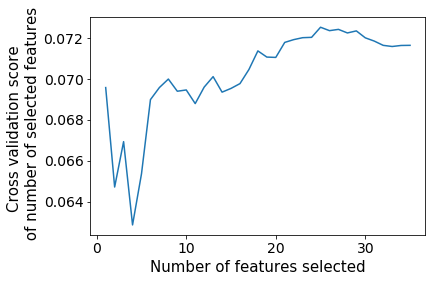

In [36]:
print('Optimal number of features :', selector.n_features_)
print('Best features :', X.columns[selector.support_])
print('Original features :', X.columns)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score \n of number of selected features")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [44]:
cols = list(X.iloc[:,selector.support_].columns) + ["relized_return", "loan_status"]

In [45]:
selected_cols = X.iloc[:,selector.support_].columns
selected_cols = list(selected_cols)

In [16]:
selected_cols = selected_cols + ["loan_status", "realized_return"]

In [20]:
dd = dd[selected_cols]

In [37]:
X_train = X_train.iloc[:,selector.support_]
X_test = X_test.iloc[:,selector.support_]

- run model with selected features

# Gradient boosting

In [38]:
GB = GradientBoostingClassifier(min_samples_split = 20)
GB.fit(X_train, y_train)

GradientBoostingClassifier(min_samples_split=20)

In [39]:
threshold = 0.3 #set threshold for classification decidion
y_prob_GB_RFE = GB.predict_proba(X_test)[:, 1] # get probability
y_pred_GB_RFE = (y_prob_GB_RFE >= threshold).astype('int')

In [40]:
res_GB_RFE = res(y_prob_GB_RFE)

In [41]:
fpr_GB_RFE, tpr_GB_RFE, thresholds = roc_curve(y_test, y_prob_GB_RFE)

In [42]:
prob_df_GB_RFE = pd.DataFrame({"prob" : y_prob_GB_RFE,"loan_status" : y_test})

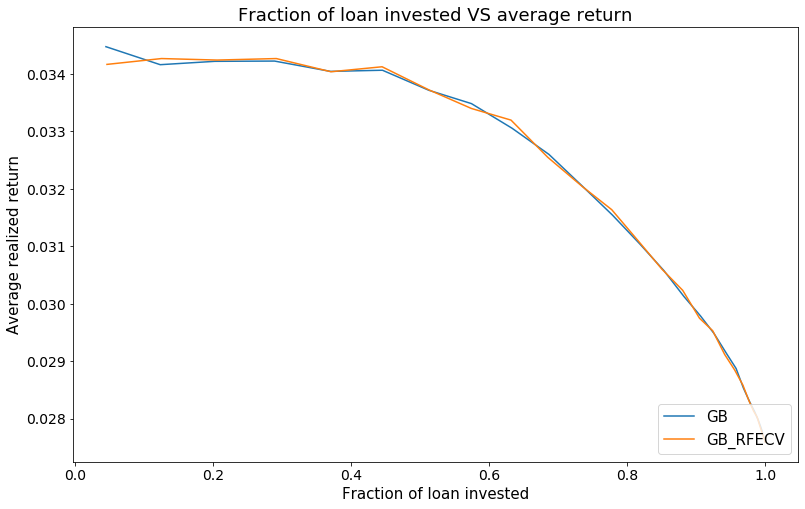

In [43]:
plt.figure(figsize = (13, 8))
plt.title("Fraction of loan invested VS average return")
plt.plot("investment_frac", "meanR", data = res_GB, label = "GB")
plt.plot("investment_frac", "meanR", data = res_GB_RFE, label = "GB_RFECV")
plt.ylabel('Average realized return')
plt.xlabel('Fraction of loan invested')
plt.legend(loc = "lower right")
plt.show()

# Outliers

In [50]:
X = dd.copy()
y = dd['loan_status']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [52]:
y_test_relized_return = X_test["realized_return"] #save the real realized return of the test loans
y_test_loan_amount = X_test["loan_amnt"] #save the real loan amnt of the test loans

In [53]:
#and now drop them
X_train = X_train.drop(['loan_status', 'realized_return'], axis=1)
X_test = X_test.drop(['loan_status', 'realized_return'], axis=1)

- model without removing outlires

# Gradient boosting

In [54]:
GB = GradientBoostingClassifier(min_samples_split = 20)
GB.fit(X_train, y_train)

GradientBoostingClassifier(min_samples_split=20)

In [55]:
threshold = 0.3 #set threshold for classification decidion
y_prob_GB = GB.predict_proba(X_test)[:, 1] # get probability
y_pred_GB = (y_prob_GB >= threshold).astype('int')

In [56]:
res_GB = res(y_prob_GB)

In [57]:
fpr_GB, tpr_GB, thresholds = roc_curve(y_test, y_prob_GB)

In [58]:
prob_df_GB = pd.DataFrame({"prob" : y_prob_GB,"loan_status" : y_test})

- detect outliers

In [59]:
from sklearn.ensemble import IsolationForest

In [60]:
clf = IsolationForest(bootstrap = True, n_estimators = 150) 
clf.fit(X_train)

IsolationForest(bootstrap=True, n_estimators=150)

In [61]:
#if_scores = clf.decision_function(X_train)
if_anomalies=clf.predict(X_train)
if_anomalies=pd.Series(if_anomalies).replace([-1,1],[1,0])


In [62]:
sum(if_anomalies)

10436

- model *with* removing outlires

In [63]:
X_train.reset_index(drop = True, inplace=True)
y_train.reset_index(drop = True, inplace=True)
X_train = X_train[if_anomalies == 0]
y_train = y_train[if_anomalies == 0]

In [64]:
GB = GradientBoostingClassifier(min_samples_split = 20)
GB.fit(X_train, y_train)

GradientBoostingClassifier(min_samples_split=20)

In [65]:
threshold = 0.3 #set threshold for classification decidion
y_prob_GB_outlier = GB.predict_proba(X_test)[:, 1] # get probability
y_pred_GB_outlier = (y_prob_GB_outlier >= threshold).astype('int')

In [66]:
res_GB_outlier = res(y_prob_GB_outlier)

In [67]:
fpr_GB_outlier, tpr_GB_outlier, thresholds = roc_curve(y_test, y_prob_GB_outlier)

In [68]:
prob_df_GB_outlier = pd.DataFrame({"prob" : y_prob_GB_outlier,"loan_status" : y_test})

- Compare results

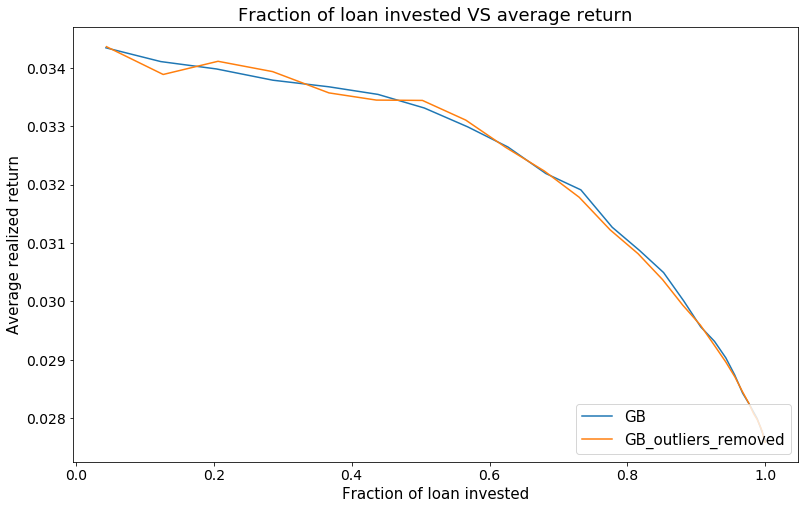

In [69]:
# investment_frac thresholds VS mean Return
plt.figure(figsize = (13, 8))
plt.title("Fraction of loan invested VS average return")
plt.plot("investment_frac", "meanR", data = res_GB, label = "GB")
plt.plot("investment_frac", "meanR", data = res_GB_outlier, label = "GB_outliers_removed")
plt.ylabel('Average realized return')
plt.xlabel('Fraction of loan invested')
plt.legend(loc = "lower right")

plt.show()

# Tuning hyper paramaters


In [70]:
X = dd.drop(['loan_status', 'realized_return'], axis=1)
y = dd['loan_status']

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

In [ ]:
clf = GradientBoostingClassifier()

param_grid = {"min_samples_split": [2, 300],
              "min_samples_leaf": [1, 150],
              "max_depth": [1, 30],
             "loss" : ["deviance", "exponential"]}
search = HalvingGridSearchCV(clf, param_grid, resource='n_estimators',
                           cv = 4, max_resources = 20, scoring = "recall").fit(X, y)

In [ ]:
selector.best_params_

In [ ]:
GB = GradientBoostingClassifier(min_samples_leaf = 500, max_depth = 10, min_samples_split = 1000)
GB.fit(X_train, y_train)

In [97]:
threshold = 0.3 #set threshold for classification decidion
y_prob_GB_Tuned = GB.predict_proba(X_test)[:, 1] # get probability
y_pred_GB_Tuned = (y_prob_GB_Tuned >= threshold).astype('int')

In [98]:
res_GB_Tuned = res(y_prob_GB_Tuned)

In [99]:
fpr_GB_Tuned, tpr_GB_Tuned, thresholds = roc_curve(y_test, y_prob_GB_Tuned)

In [100]:
prob_df_GB_Tuned = pd.DataFrame({"prob" : y_prob_GB_Tuned,"loan_status" : y_test})

- Compare results

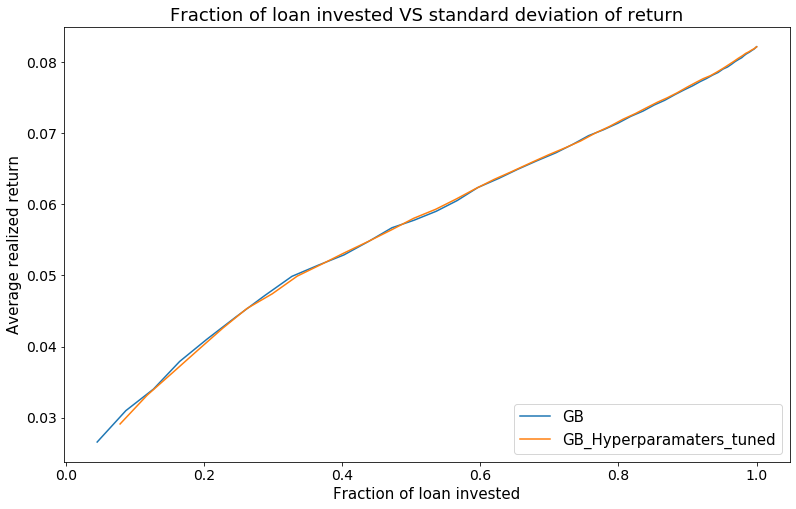

In [111]:
# investment_frac thresholds VS mean Return
plt.figure(figsize = (13, 8))
plt.title("Fraction of loan invested VS standard deviation of return")
plt.plot("investment_frac", "sdmeanR", data = res_GB, label = "GB")
plt.plot("investment_frac", "sdmeanR", data = res_GB_Tuned, label = "GB_Hyperparamaters_tuned")
plt.ylabel('Average realized return')
plt.xlabel('Fraction of loan invested')
plt.legend(loc = "lower right")

plt.show()

# Model comperassion

 - ROC

In [ ]:
plt.figure(figsize = (13, 4.5))

plt.title("ROC Curves")
plt.plot(fpr_GB, tpr_GB, label = "GB : AUC = %.3f" % roc_auc_score(y_test, y_prob_GB))
plt.plot(fpr_LG, tpr_LG, label = "LG : AUC = %.3f" % roc_auc_score(y_test, y_prob_LG))
plt.plot(fpr_RF, tpr_RF, label = "RF : AUC = %.3f" % roc_auc_score(y_test, y_prob_RF))
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = "lower right")
plt.show()

- thresholds VS mean Return

In [ ]:
#thresholds VS mean Return
plt.figure(figsize = (13, 8))
plt.title("Threshold VS average return")
plt.plot("c_thresholds", "meanR", data = res_GB, label = "GB")
plt.plot("c_thresholds", "meanR", data = res_RF, label = "RF")
plt.plot("c_thresholds", "meanR", data = res_LG, label = "LG")
plt.ylabel('Average realized return')
plt.xlabel('Threshold to predict as default')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
# investment_frac thresholds VS mean Return
plt.figure(figsize = (13, 8))
plt.title("Fraction of loan invested VS average return")
plt.plot("investment_frac", "meanR", data = res_GB, label = "GB")
plt.plot("investment_frac", "meanR", data = res_RF, label = "RF")
plt.plot("investment_frac", "meanR", data = res_LG, label = "LG")
plt.ylabel('Average realized return')
plt.xlabel('Fraction of loan invested')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
# investment_frac thresholds VS mean Return
plt.figure(figsize = (13, 8))
plt.title("Amount invested  VS average return")
plt.plot("investment", "meanR", data = res_GB, label = "GB")
plt.plot("investment", "meanR", data = res_RF, label = "RF")
plt.plot("investment", "meanR", data = res_LG, label = "LG")
plt.ylabel('Average realized return')
plt.xlabel('Amount invested (in hundreds of million)')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
# investment_frac SD VS SD Return
plt.figure(figsize = (13, 8))
plt.title("Fraction of loan invested VS standard deviation of return")
plt.plot("investment_frac", "sdmeanR", data = res_GB, label = "GB")
plt.plot("investment_frac", "sdmeanR", data = res_RF, label = "RF")
plt.plot("investment_frac", "sdmeanR", data = res_LG, label = "LG")
plt.ylabel('SD realized return')
plt.xlabel('Fraction of loan invested')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
# investment_frac SD VS SD Return
plt.figure(figsize = (13, 8))
#plt.title("Fraction of loan invested VS standard deviation of return")
plt.plot("investment_frac", "Mean_diff", data = diff, label = "GB")
#plt.ylabel('SD realized returndiff')
plt.xlabel('Fraction of loan invested')
plt.legend(loc = "lower right")
plt.show()

# investment_frac SD VS SD Return
plt.figure(figsize = (13, 8))
#plt.title("Fraction of loan invested VS standard deviation of return")
plt.plot("investment_frac", "sd_diff", data = diff, label = "GB")
#plt.ylabel('SD realized returndiff')
plt.xlabel('Fraction of loan invested')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
plt.figure(figsize = (13, 8))
plt.title("Amount invested VS standard deviation of return")
plt.plot("investment", "sdmeanR", data = res_GB, label = "GB")
plt.plot("investment", "sdmeanR", data = res_RF, label = "RF")
plt.plot("investment", "sdmeanR", data = res_LG, label = "LG")
plt.ylabel('SD realized return')
plt.xlabel('Amount invested (in hundreds of million)')
plt.legend(loc = "lower right")
plt.show()